# This Notebook will include graphical analysis of Amazon review data

Source:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects.

Jianmo Ni, Jiacheng Li, Julian McAuley.

Empirical Methods in Natural Language Processing (EMNLP), 2019.

https://nijianmo.github.io/amazon/index.html

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

------------------------------

Sentiment analysis code shall be later on transfered to .py files for easy execution

---------------

# Data Transformation

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math
from scipy.spatial import distance
from sklearn.metrics import accuracy_score

# custom files
from word_vectorization import create_tf_vector_all_reviews, create_idf_dictionary, create_word_vector_dict
from data_transformation import get_overview, clean_data, balancing

--------

## Import Data

In [2]:
# read subset data
#path = "./data/AMAZON_FASHION_5.json"

#data = pd.read_json(path, lines = True)

# read full data
path = "./data/AMAZON_FASHION_FULL.json"

data = pd.read_json(path, lines = True)

-------

# Data overview

In [3]:
get_overview(data)

Data has 883636 datapoints.
Data has 12 columns.
Columns: dtype
{'overall': 'int64', 'verified': 'bool', 'reviewTime': 'object', 'reviewerID': 'object', 'asin': 'object', 'reviewerName': 'object', 'reviewText': 'object', 'summary': 'object', 'unixReviewTime': 'int64', 'vote': 'float64', 'style': 'object', 'image': 'object'}


--------

## Data Cleaning

In [4]:
keepColumns = ["overall", "reviewText"]
data = clean_data(data, keepColumns)

Dropped 10 columns.
Droppend 1233 null values.
Data contains now 882403 datapoints.


-------

## Balancing

Most saved rating is 5 with 464591 datapoints.
Least saved rating is 2 with 64690 datapoints.


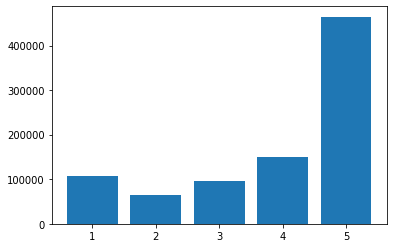

In [5]:
max_num = 2000 # replace lateron
data = balancing(data, balancing = True, max_num = max_num)

Most saved rating is 1 with 2000 datapoints.
Least saved rating is 1 with 2000 datapoints.


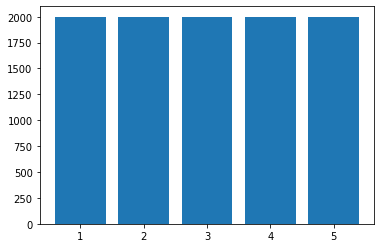

In [6]:
# check balancing
balancing(data, balancing = False, max_num = None)

-------

## Word Vectors

In [7]:
def save_dict_to_json(dic, filename):
    
    # append .json
    filename += ".json"
    
    f = open(filename, "w")
    json.dump(dic, f)
    f.close()

def load_doc_from_json(filename):
    
    # append .json
    filename += ".json"
    
    f = open(filename, "w")
    dic = f.read()
    f.close()

In [8]:
# create review_dict
review_dict = create_tf_vector_all_reviews(data)
save_dict_to_json(review_dict, "review_dict")

# create idf dict
idf_dict = create_idf_dictionary(review_dict)
save_dict_to_json(idf_dict, "idf_dict")

# create word_vec_dict
word_vec_dict = create_word_vector_dict(review_dict, idf_dict) # speed = 0.2 seconds per datapoint
np.save('word_vec_dict.npy', word_vec_dict)

# include word_vec_dict in dataframe
data["word_vectors"] = word_vec_dict.values()

In [9]:
# alternative without processing word vectors
word_vec_dict = np.load('word_vec_dict.npy', allow_pickle=True)[()]
data["word_vectors"] = word_vec_dict.values()
data.to_json("data_with_word_vectors")

In [15]:
# get a look at the data
data.head()

,overall,reviewText,word_vectors
0,2,"I agree with the other review, the opening is ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,too tiny an opening,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,I smoke 100's and these are NOT made for them....,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2,"It's ok, It doesn't close if you have 100's","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2,Is very small. Doesn't fit my smokes...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


------

## Train Test Split

In [17]:
# create test and training dataset
test_size = 0.2
train_data, test_data = train_test_split(data,
                                         test_size = test_size,
                                         shuffle=True,
                                         stratify = data["overall"]
                                        )

train_data = train_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

-------

# Now start Sentiment analysis

-------

## knn

In [ ]:
# test single n

# init variables
data_point = test_data[:1]
data_point_class = data_point["overall"]
n = 3

# calc class
calc_class = knn(train_data, data_point)

print(f"Test Datapoint has class: {calc_class}")

In [ ]:
# test multiple n

# init variables
data_point = test_data[:1]
data_point_class = data_point["overall"]
n = [1,2,3,4,5]

# calc class
calc_class = knn(train_data, data_point)

print(f"Test Datapoint has class: {calc_class}")

In [ ]:
# test accuracy

# get test data
test_vectors = test_data["word_vectors"].to_list()
test_classes = test_data["overall"].to_list()

# init variables
pred_class = []
n_test = list(range(1,30))

# get classes 
for t_vector in test_vectors:

    pred_class.append(knn(train_data, np.asarray(t_vector), n_test))
    
# init accuracy dict
acc_dict = {}

for sub_n in n_test:
    
    sub_n_val_classes = []
    
    for test_el in pred_class:
        
        sub_n_val_classes.append(test_el[sub_n])
    
    # get accuracy of sub_n
    accuracy = accuracy_score(test_classes, sub_n_val_classes)
    acc_dict[sub_n] = accuracy

# visualize
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.show()

----

In [19]:
# Implement K nearest Neigbours
def knn(train_data, data_point, n):
    
    vectors = train_data["word_vectors"].to_list()
    
    distances = {}
    count = 0
    
    for vector in vectors:
        
        distances[count] = distance.euclidean(data_point, np.asarray(vector))
        count += 1
    
    # sort dictionary
    distances = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}
    
    classes_indexes = list(distances.keys())[:n]
    classes = {}
    
    for i in classes_indexes:
        
        if train_data.iloc[i]["overall"] in list(classes.keys()):
            
            classes[train_data.iloc[i]["overall"]] += 1
        
        else:
            
            classes[train_data.iloc[i]["overall"]] = 1
    
    max_class = max(classes, key = classes.get)
    
    return max_class

In [20]:
test_vectors = test_data["word_vectors"].to_list()
test_classes = test_data["overall"].to_list()

In [21]:
def test(n_test):

    pred_class = []
    for t_vector in test_vectors:

        pred_class.append(knn(train_data, np.asarray(t_vector), n_test))

    accuracy = accuracy_score(test_classes, pred_class)
    #print(f"accuracy is: {accuracy}")
    return accuracy

In [ ]:
evalualtion_dict = {}

for n_test in range(1, 30):
    
    evalualtion_dict[n_test] = test(n_test)

In [ ]:
# visualize
plt.plot(list(evalualtion_dict.keys()), list(evalualtion_dict.values()))
plt.show()

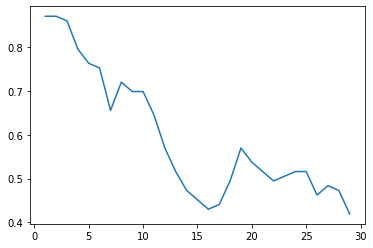

In [98]:
# visualize 
plt.plot(list(evalualtion_dict.keys()), list(evalualtion_dict.values()))
plt.show()

----------

Task: knn in own python file, rewrite to be completly independent of other libs

-------------

In [39]:
test = vectors[1]
train = vectors[0]

In [75]:
data_point = np.asarray(test_data.loc[0]["word_vectors"])

In [76]:
print(knn(train_data, data_point, 10))

2


In [70]:
test_data.head(10)

,overall,reviewText,summary,word_vectors
0,3,Nice,Three Stars,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,3,They're ugly: the toe is rounded and the mater...,the Nike Womens Flex Trainer 6 is way better l...,"(0.0, 0.0, 0.30975149678639335, 0.0, 0.0, 0.0,..."
2,1,Ordered 9(m) received 9 Wide for the second ti...,One Star,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,I've not even had them a month and the bottom ...,Falling apart already!!,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,3,"I bought a pair of these in my size, but they ...",Get a half-size or more larger than usual.,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,4,Very good overall.\nNow Ive been a huge Sketch...,Good shoes,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,1,Waaaay too BIG,One Star,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,5,Great shoes. Fit perfectly. Comfortable right ...,Great shoes. Fit perfectly,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,2,I returned these as they were not true to size...,Not true to size,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,3,No arch support but l love the colors!,Three Stars,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
